# Sentiment Analysis

Now, we have our cleaned dataset. We can start do our sentiment analysis on the comments about ```VOO``` from Subreddit ```r/ETFs```.

### Import Modules

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [157]:
seed = 8888

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Import the datasets

In [158]:
cmts_voo = pd.read_csv('../datasets/cleaned_cmts_voo.csv')
cmts_voo.head()

,author,id,created_utc,permalink,body,score,subreddit
0,lotterytix,kwh3sji,2024-03-25 20:10:23,/r/ETFs/comments/1bmqbxg/new_to_investing_is_v...,Maybe consider VOO and a mid/small cap value f...,1,ETFs
1,AlgoTradingQuant,kwczgum,2024-03-25 00:51:21,/r/ETFs/comments/1bmoom7/diversifying_my_ira_f...,I’m retired and hold a 100% equities portfolio...,8,ETFs
2,foldinthechhese,kwdbk25,2024-03-25 02:02:08,/r/ETFs/comments/1bmoom7/diversifying_my_ira_f...,The more experienced investors recommend a ble...,5,ETFs
3,SirChetManly,kwd6nto,2024-03-25 01:33:43,/r/ETFs/comments/1bmoom7/diversifying_my_ira_f...,It isn't *risky* by any stretch. You're exclud...,2,ETFs
4,ZAROV8862,kwei3zo,2024-03-25 06:17:54,/r/ETFs/comments/1bmoom7/diversifying_my_ira_f...,Enough said :)),2,ETFs


### Using Transformer Model in Sentiment Analysis

We will be using ```BERT-Base-Uncased``` model. 

```BERT```: BERT stands for Bidirectional Encoder Representations from Transformers. It's a groundbreaking model introduced by Google in 2018 that revolutionized the field of natural language processing (NLP). BERT is known for its deep understanding of language context, which it achieves through its transformer architecture.

```Base```: The "base" in "bert-base-uncased" indicates the size of the model. BERT typically comes in two sizes: base and large. The base model is smaller and faster, making it more practical for many applications, though the large model generally performs better on NLP tasks. The base model has 110 million parameters, while the large model has 340 million.

```Uncased```: This specifies that the model was trained on text that has been converted to lowercase, meaning the model does not differentiate between uppercase and lowercase letters. This is in contrast to a "cased" model, which is sensitive to letter casing. For instance, in a cased model, "Hello" and "hello" would be treated differently, whereas they would be treated the same in an uncased model.

The tokenizer we used here is ```AutoTokenizer``` from ```Hugging Face```. 
More detail can check at https://huggingface.co/docs/transformers/v4.39.2/en/autoclass_tutorial#autotokenizer

Token indices sequence length is longer than the specified maximum sequence length for this model (1224 > 512). Running this sequence through the model will result in indexing errors


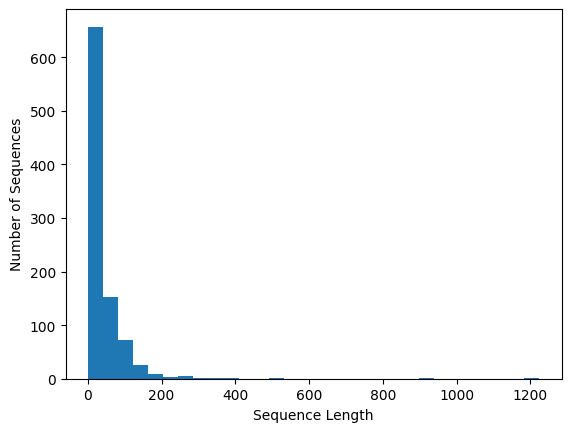

In [161]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

transformer_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(transformer_name)

lengths = cmts['body'].apply(lambda x: len(tokenizer.tokenize(x)))

plt.hist(lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.show()

In [162]:
max_length = 512

tokenized_input = cmts['body'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=max_length))

Here is an example of tokenization and numericalization. 

In [163]:
tokenizer.tokenize("We are doing sentiment analysis!")

['we', 'are', 'doing', 'sentiment', 'analysis', '!']

In [164]:
tokenizer.encode("We are doing sentiment analysis!")

[101, 2057, 2024, 2725, 15792, 4106, 999, 102]

In [165]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("We are doing sentiment analysis!"))

['[CLS]', 'we', 'are', 'doing', 'sentiment', 'analysis', '!', '[SEP]']

In [166]:
tokenizer("We are doing sentiment analysis!")

{'input_ids': [101, 2057, 2024, 2725, 15792, 4106, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}